In [ ]:
%load_ext autoreload
%autoreload 2
#========================================================================
# Args
#========================================================================
learning_rate = 0.1
early_stopping_rounds = 100
num_boost_round = 10000
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'purchase_date']

import gc
import sys
import numpy as np
import pandas as pd
import datetime

import shutil
import glob
import os
HOME = os.path.expanduser('~')

sys.path.append(f'{HOME}/kaggle/data_analysis/model')
from params_lgbm import params_elo
sys.path.append(f'{HOME}/kaggle/data_analysis')
from model.lightgbm_ex import lightgbm_ex as lgb_ex

sys.path.append(f"{HOME}/kaggle/data_analysis/library/")
import utils
from preprocessing import get_ordinal_mapping
from utils import logger_func
try:
    if not logger:
        logger=logger_func()
except NameError:
    logger=logger_func()

params = params_elo()
params['learning_rate'] = learning_rate

start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())

#========================================================================
# Data Load
base = utils.read_df_pkl('../input/base*')
win_path_list = glob.glob('../features/4_winner/*.gz')
train_path_list = []
test_path_list = []
for path in win_path_list:
    if path.count('train'):
        train_path_list.append(path)
    elif path.count('test'):
        test_path_list.append(path)

base_train = base[~base[target].isnull()].reset_index(drop=True)
base_test = base[base[target].isnull()].reset_index(drop=True)
train_feature_list = utils.pararell_load_data(path_list=train_path_list)
test_feature_list = utils.pararell_load_data(path_list=test_path_list)
train = pd.concat(train_feature_list, axis=1)
train = pd.concat([base_train, train], axis=1)
test = pd.concat(test_feature_list, axis=1)
test = pd.concat([base_test, test], axis=1)
#========================================================================

#========================================================================
# LGBM Setting
model_type='lgb'
metric = 'rmse'
fold=2
seed=1208
LGBM = lgb_ex(logger=logger, metric=metric, model_type=model_type, ignore_list=ignore_list)


train, test, drop_list = LGBM.data_check(train=train, test=test, target=target, encode='dummie', exclude_category=True)

ignore_list = [key, target, 'merchant_id', 'purchase_date']

#========================================================================
# Train & Prediction Start
#========================================================================
import lightgbm as lgb

# TrainとCVのfoldを合わせる為、Train
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

y = train[target]
tmp_train = train.drop(target, axis=1)

folds = KFold(n_splits=fold, shuffle=True, random_state=seed)
kfold = list(folds.split(tmp_train, y))

use_cols = [col for col in train.columns if col not in ignore_list]
valid_feat_list = use_cols.copy()
best_valid_list = [100, 100]
valid_log_list = []
oof_log = train[[key, target]]
decrease_list = []

for i, valid_feat in enumerate([''] + valid_feat_list):
    
    logger.info(f'''
#========================================================================
# Valid{i}/{len(valid_feat_list)} Start!!
# Valid Feature: {valid_feat}
#========================================================================''')
    update_cnt = 0
    score_list = []
    oof = np.zeros(len(train))
    
    # One by One Decrease
    if len(valid_feat)>0:
        valid_cols = list(set(use_cols) - set([valid_feat]))
    else:
        valid_cols = use_cols.copy()

    for n_fold, (trn_idx, val_idx) in enumerate(kfold):
        x_train, y_train = tmp_train[valid_cols].loc[trn_idx, :], y.loc[trn_idx]
        x_val, y_val = tmp_train[valid_cols].loc[val_idx, :], y.loc[val_idx]
        
        lgb_train = lgb.Dataset(data=x_train, label=y_train)
        lgb_eval = lgb.Dataset(data=x_val, label=y_val)
        
        lgbm = lgb.train(
            train_set=lgb_train,
            valid_sets=lgb_eval,
            params=params,
            verbose_eval=200,
            early_stopping_rounds=early_stopping_rounds,
            num_boost_round=num_boost_round,
        )
        
        y_pred = lgbm.predict(x_val)
        oof[val_idx] = y_pred
        
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        score_list.append(score)
        if score <  best_valid_list[n_fold]:
            best_valid_list[n_fold]=score
            update_cnt+=1
        logger.info(f"Validation {n_fold}: RMSE {score}")
        
    valid_log_list.append(score_list+[np.mean(score_list)])
    oof_log[f'valid{i}'] = oof
    
    if len(valid_feat)==0:
        continue
        
    # move feature
    if update_cnt==fold:
        logger.info(f"""
# ==============================
# Score Update!!
# Decrease: {valid_feat}
# Score   : {np.mean(score_list)}
# ==============================
        """)
        path_list = glob.glob(win_path)
        move_list = [path for path in path_list if path.count(valid_feat)]
        for move_path in move_list:
            shutil.move(move_path, '../features/9_gdrive/')
        decrease_list.append(valid_feat)
        
effect_feat = pd.Series(np.ones(len(use_cols)), index=use_cols, name='effective')
effect_feat.loc[decrease_list] = 0

df_valid_log = pd.DataFrame(np.array(valid_log_list), columns=['valid1', 'valid2', 'cv'])


100%|██████████| 3/3 [00:00<00:00, 81.53it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2018-12-02 20:18:39,177 utils 213 [INFO]    [data_check] 
#==============================================================================
# DATA CHECK START
# CATEGORICAL FEATURE: []
# DATETIME FEATURE   : []
# CAT ENCODE         : dummie
# ignore_list        : ['card_id', 'target', 'merchant_id', 'purchase_date']
#==============================================================================
         
2018-12-02 20:18:40,238 utils 235 [INFO]    [data_check] 
***********WARNING************* LENGTH 0 COLUMN: first1_diff_days_lag1@ 
2018-12-02 20:18:40,239 utils 235 [INFO]    [data_check] 
***********WARNING************* LENGTH 0 COLUMN: first1_diff_days_lag2@ 
2018-12-02 20:18:40,241 utils 235 [INFO]    [data_check] 
***********WARNING************* LENGTH 0 COLUMN: first1_diff_days_lag3@ 
2018-12-02 20:18:40,242 utils 235 [INFO]    [data_check] 
***********WARNING************* LENGTH 0 COLUMN: first1_ratio_days_lag1_2@ 
2018-12-02 20:18:40,243 utils 235 [INFO]    [data_check] 
*********

FileNotFound. : first1_diff_days_lag1@.gz
FileNotFound. : first1_diff_days_lag2@.gz
FileNotFound. : first1_diff_days_lag3@.gz
FileNotFound. : first1_ratio_days_lag1_2@.gz
FileNotFound. : first1_ratio_days_lag1_3@.gz
FileNotFound. : first1_ratio_days_lag2_3@.gz
FileNotFound. : month_lag_nuq@card_id-month_lag1.gz
FileNotFound. : month_lag_nuq@card_id-month_lag2.gz


2018-12-02 20:18:40,525 utils 244 [INFO]    [data_check] 
#==============================================================================
# DATA CHECK END
# SHAPE: (325540, 220)
#============================================================================== 

0it [00:00, ?it/s]2018-12-02 20:18:40,678 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid0/218 Start!!
# Valid Feature: 
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[62]	valid_0's l2: 14.4308


2018-12-02 20:18:45,135 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.798785733627068 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.2103


2018-12-02 20:18:49,432 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7696493061768224 

1it [00:09,  9.01s/it]2018-12-02 20:18:49,690 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid1/218 Start!!
# Valid Feature: W0_95_TE1208_category_1@@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	valid_0's l2: 14.4477


2018-12-02 20:18:53,514 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.801019266370378 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[78]	valid_0's l2: 14.1913


2018-12-02 20:18:57,981 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767129399659797 

2it [00:17,  8.82s/it]2018-12-02 20:18:58,057 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid2/218 Start!!
# Valid Feature: W0_95_TE1208_category_2@@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[37]	valid_0's l2: 14.4372


2018-12-02 20:19:01,985 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799629470315289 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's l2: 14.1747


2018-12-02 20:19:06,120 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7649330134476955 

3it [00:25,  8.61s/it]2018-12-02 20:19:06,188 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid3/218 Start!!
# Valid Feature: W0_95_TE1208_category_3@@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.4311


2018-12-02 20:19:10,135 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7988287180522535 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.1975


2018-12-02 20:19:14,306 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7679568044556944 

4it [00:33,  8.48s/it]2018-12-02 20:19:14,373 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid4/218 Start!!
# Valid Feature: W0_95_TE1208_city_id@@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's l2: 14.4491


2018-12-02 20:19:18,507 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8011947822092615 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.1895


2018-12-02 20:19:22,632 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7668966296064212 

5it [00:42,  8.44s/it]2018-12-02 20:19:22,704 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid5/218 Start!!
# Valid Feature: W0_95_TE1208_merchant_category_id@@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's l2: 14.4398


2018-12-02 20:19:34,959 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7999746442016837 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	valid_0's l2: 14.1912


2018-12-02 20:19:39,225 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7671239395696743 

7it [00:58,  8.36s/it]2018-12-02 20:19:39,300 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid7/218 Start!!
# Valid Feature: W0_95_TE1208_subsector_id@@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4349


2018-12-02 20:19:43,488 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7993336203909345 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.2036


2018-12-02 20:19:47,518 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7687719748077826 

8it [01:06,  8.34s/it]2018-12-02 20:19:47,590 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid8/218 Start!!
# Valid Feature: W0_95_diff_days_lag1@@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[41]	valid_0's l2: 14.4296


2018-12-02 20:19:51,659 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7986332562502887 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.1962


2018-12-02 20:19:55,796 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767785567319659 

9it [01:15,  8.32s/it]2018-12-02 20:19:55,869 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid9/218 Start!!
# Valid Feature: W0_95_diff_days_lag2@@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.4348


2018-12-02 20:19:59,818 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799316786935152 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[53]	valid_0's l2: 14.2181


2018-12-02 20:20:03,708 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7706868338280177 

10it [01:23,  8.20s/it]2018-12-02 20:20:03,776 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid10/218 Start!!
# Valid Feature: W0_95_diff_days_lag3@@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.4261


2018-12-02 20:20:08,073 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7981695435441454 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.2042


2018-12-02 20:20:12,126 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7688435647463976 

11it [01:31,  8.26s/it]2018-12-02 20:20:12,195 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid11/218 Start!!
# Valid Feature: W0_95_installments@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.4364


2018-12-02 20:20:16,203 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7995304915437624 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[53]	valid_0's l2: 14.2089


2018-12-02 20:20:20,125 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7694680632499677 

12it [01:39,  8.19s/it]2018-12-02 20:20:20,199 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid12/218 Start!!
# Valid Feature: W0_95_purchase_amount@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[38]	valid_0's l2: 14.4503


2018-12-02 20:20:23,886 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8013600854296334 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's l2: 14.1897


2018-12-02 20:20:27,992 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.766918938267146 

13it [01:47,  8.09s/it]2018-12-02 20:20:28,060 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid13/218 Start!!
# Valid Feature: W0_95_ratio_days_lag1_2@@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.4355


2018-12-02 20:20:32,921 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799403945323955 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[83]	valid_0's l2: 14.1951


2018-12-02 20:20:37,560 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7676377300502413 

14it [01:56,  8.53s/it]2018-12-02 20:20:37,628 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid14/218 Start!!
# Valid Feature: W0_95_ratio_days_lag1_3@@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[55]	valid_0's l2: 14.4267


2018-12-02 20:20:41,625 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.798244342336064 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	valid_0's l2: 14.1936


2018-12-02 20:20:46,059 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7674349734509405 

15it [02:05,  8.52s/it]2018-12-02 20:20:46,134 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid15/218 Start!!
# Valid Feature: W0_95_ratio_days_lag2_3@@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's l2: 14.4359


2018-12-02 20:20:50,334 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799464893811024 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.1909


2018-12-02 20:20:54,668 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7670750833475686 

16it [02:14,  8.55s/it]2018-12-02 20:20:54,748 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid16/218 Start!!
# Valid Feature: category_1_nuq@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.4458


2018-12-02 20:20:58,921 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800768262366005 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[83]	valid_0's l2: 14.2012


2018-12-02 20:21:03,363 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7684476750535385 

17it [02:22,  8.59s/it]2018-12-02 20:21:03,442 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid17/218 Start!!
# Valid Feature: category_1_nuq@card_id-month_lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's l2: 14.445


2018-12-02 20:21:07,731 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8006633252022537 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.2144


2018-12-02 20:21:12,662 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.77019892926893 

18it [02:32,  8.80s/it]2018-12-02 20:21:12,735 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid18/218 Start!!
# Valid Feature: category_1_nuq@card_id-month_lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's l2: 14.444


2018-12-02 20:21:16,619 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8005217542902656 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.1911


2018-12-02 20:21:20,921 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7671120871523778 

19it [02:40,  8.64s/it]2018-12-02 20:21:20,996 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid19/218 Start!!
# Valid Feature: category_2_nuq@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	valid_0's l2: 14.4371


2018-12-02 20:21:25,060 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7996120665379687 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.2013


2018-12-02 20:21:32,765 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7684580104404097 

20it [02:52,  9.60s/it]2018-12-02 20:21:32,847 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid20/218 Start!!
# Valid Feature: category_2_nuq@card_id-month_lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.4307


2018-12-02 20:21:42,007 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.798780914115212 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[86]	valid_0's l2: 14.2029


2018-12-02 20:21:52,781 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768674304272452 

21it [03:12, 12.75s/it]2018-12-02 20:21:52,947 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid21/218 Start!!
# Valid Feature: category_2_nuq@card_id-month_lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.4345


2018-12-02 20:22:02,203 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7992756453736187 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's l2: 14.2072


2018-12-02 20:22:12,613 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.769240557149314 

22it [03:32, 14.88s/it]2018-12-02 20:22:12,804 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid22/218 Start!!
# Valid Feature: category_3_nuq@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[53]	valid_0's l2: 14.4384


2018-12-02 20:22:23,657 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799791226388878 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's l2: 14.1986


2018-12-02 20:22:34,523 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7681003747433053 

23it [03:53, 16.98s/it]2018-12-02 20:22:34,677 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid23/218 Start!!
# Valid Feature: category_3_nuq@card_id-month_lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[56]	valid_0's l2: 14.4343


2018-12-02 20:22:44,063 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799256380433983 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.2007


2018-12-02 20:22:54,868 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768385822956944 

24it [04:14, 17.99s/it]2018-12-02 20:22:55,032 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid24/218 Start!!
# Valid Feature: category_3_nuq@card_id-month_lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's l2: 14.4428


2018-12-02 20:23:05,113 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800367616761638 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[92]	valid_0's l2: 14.191


2018-12-02 20:23:16,311 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767094282443491 

25it [04:35, 19.03s/it]2018-12-02 20:23:16,497 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid25/218 Start!!
# Valid Feature: city_id_nuq@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[46]	valid_0's l2: 14.4384


2018-12-02 20:23:25,983 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7997935683794335 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.2036


2018-12-02 20:23:34,687 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768765742615278 

26it [04:54, 18.83s/it]2018-12-02 20:23:34,847 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid26/218 Start!!
# Valid Feature: city_id_nuq@card_id-month_lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.4186


2018-12-02 20:23:44,381 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7971793838238033 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's l2: 14.1993


2018-12-02 20:23:54,795 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7681919672359188 

27it [05:14, 19.19s/it]2018-12-02 20:23:54,877 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid27/218 Start!!
# Valid Feature: city_id_nuq@card_id-month_lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[46]	valid_0's l2: 14.4398


2018-12-02 20:24:04,515 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7999680135508127 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[83]	valid_0's l2: 14.188


2018-12-02 20:24:15,020 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7666961318385015 

28it [05:34, 19.50s/it]2018-12-02 20:24:15,105 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid28/218 Start!!
# Valid Feature: feature_1@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[56]	valid_0's l2: 14.4432


2018-12-02 20:24:24,260 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800420808410876 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[89]	valid_0's l2: 14.2101


2018-12-02 20:24:34,889 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7696252441242986 

29it [05:54, 19.61s/it]2018-12-02 20:24:34,972 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid29/218 Start!!
# Valid Feature: feature_2@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[48]	valid_0's l2: 14.4375


2018-12-02 20:24:44,311 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7996687876954547 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[68]	valid_0's l2: 14.1918


2018-12-02 20:24:54,494 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7672057662385634 

30it [06:13, 19.63s/it]2018-12-02 20:24:54,650 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid30/218 Start!!
# Valid Feature: feature_3@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.4317


2018-12-02 20:25:04,572 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7989052557826657 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's l2: 14.185


2018-12-02 20:25:15,057 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7662994033539468 

31it [06:34, 19.92s/it]2018-12-02 20:25:15,227 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid31/218 Start!!
# Valid Feature: first1_TE1208_category_1@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's l2: 14.4455


2018-12-02 20:25:25,164 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800728166192463 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.1981


2018-12-02 20:25:35,310 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768036395275797 

32it [06:54, 20.01s/it]2018-12-02 20:25:35,471 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid32/218 Start!!
# Valid Feature: first1_TE1208_category_2@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4457


2018-12-02 20:25:44,717 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8007447428005925 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.1874


2018-12-02 20:25:54,264 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7666230875531967 

33it [07:13, 19.67s/it]2018-12-02 20:25:54,338 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid33/218 Start!!
# Valid Feature: first1_TE1208_category_3@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[50]	valid_0's l2: 14.4406


2018-12-02 20:26:04,141 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8000726691401914 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.2069


2018-12-02 20:26:14,866 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.769204014273731 

34it [07:34, 19.98s/it]2018-12-02 20:26:15,058 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid34/218 Start!!
# Valid Feature: first1_TE1208_city_id@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.4368


2018-12-02 20:26:23,387 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7995815320738884 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	valid_0's l2: 14.206


2018-12-02 20:26:32,667 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7690845568358906 

35it [07:52, 19.32s/it]2018-12-02 20:26:32,816 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid35/218 Start!!
# Valid Feature: first1_TE1208_merchant_category_id@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.4393


2018-12-02 20:26:42,423 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7999056826028546 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[64]	valid_0's l2: 14.209


2018-12-02 20:26:51,515 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7694872413993363 

36it [08:10, 19.16s/it]2018-12-02 20:26:51,598 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid36/218 Start!!
# Valid Feature: first1_TE1208_state_id@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's l2: 14.4421


2018-12-02 20:27:01,321 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8002758895211293 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.2


2018-12-02 20:27:11,525 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768282132362678 

37it [08:30, 19.41s/it]2018-12-02 20:27:11,609 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid37/218 Start!!
# Valid Feature: first1_TE1208_subsector_id@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4442


2018-12-02 20:27:21,140 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800555575403259 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.2116


2018-12-02 20:27:31,548 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7698236233025098 

38it [08:51, 19.62s/it]2018-12-02 20:27:31,710 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid38/218 Start!!
# Valid Feature: first1_diff_days_lag1@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4426


2018-12-02 20:27:41,218 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.80034782789655 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.2138


2018-12-02 20:27:52,019 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7701139052200343 

39it [09:11, 19.87s/it]2018-12-02 20:27:52,164 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid39/218 Start!!
# Valid Feature: first1_diff_days_lag2@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4426


2018-12-02 20:28:01,564 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.80034782789655 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.2138


2018-12-02 20:28:11,822 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7701139052200343 

40it [09:31, 19.87s/it]2018-12-02 20:28:12,027 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid40/218 Start!!
# Valid Feature: first1_diff_days_lag3@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4426


2018-12-02 20:28:21,204 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.80034782789655 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.2138


2018-12-02 20:28:26,037 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7701139052200343 

41it [09:45, 18.13s/it]2018-12-02 20:28:26,114 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid41/218 Start!!
# Valid Feature: first1_ratio_days_lag1_2@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4426


2018-12-02 20:28:30,245 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.80034782789655 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.2138


2018-12-02 20:28:34,511 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7701139052200343 

42it [09:53, 15.23s/it]2018-12-02 20:28:34,580 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid42/218 Start!!
# Valid Feature: first1_ratio_days_lag1_3@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4426


2018-12-02 20:28:38,891 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.80034782789655 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.2138


2018-12-02 20:28:43,204 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7701139052200343 

43it [10:02, 13.27s/it]2018-12-02 20:28:43,276 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid43/218 Start!!
# Valid Feature: first1_ratio_days_lag2_3@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4426


2018-12-02 20:28:47,530 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.80034782789655 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.2138


2018-12-02 20:28:51,855 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7701139052200343 

44it [10:11, 11.89s/it]2018-12-02 20:28:51,927 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid44/218 Start!!
# Valid Feature: first3_installments_1_diff_2@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[64]	valid_0's l2: 14.4407


2018-12-02 20:28:56,351 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800085901871105 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's l2: 14.194


2018-12-02 20:29:00,654 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7674988836886074 

45it [10:20, 10.96s/it]2018-12-02 20:29:00,722 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid45/218 Start!!
# Valid Feature: first3_installments_1_diff_3@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[62]	valid_0's l2: 14.4326


2018-12-02 20:29:08,716 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7990252257445865 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's l2: 14.196


2018-12-02 20:29:13,343 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7677600588310556 

46it [10:32, 11.48s/it]2018-12-02 20:29:13,411 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid46/218 Start!!
# Valid Feature: first3_installments_1_div_2@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4271


2018-12-02 20:29:17,565 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.798303006179464 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[90]	valid_0's l2: 14.2117


2018-12-02 20:29:21,989 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7698346132059313 

47it [10:41, 10.63s/it]2018-12-02 20:29:22,057 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid47/218 Start!!
# Valid Feature: first3_installments_1_div_3@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.4298


2018-12-02 20:29:26,320 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7986591260566445 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[85]	valid_0's l2: 14.1896


2018-12-02 20:29:30,566 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7669081589013396 

48it [10:49, 10.01s/it]2018-12-02 20:29:30,634 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid48/218 Start!!
# Valid Feature: first3_purchase_amount_1_diff_2@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's l2: 14.4444


2018-12-02 20:29:34,937 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8005759493028477 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	valid_0's l2: 14.2028


2018-12-02 20:29:39,138 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7686563564102062 

49it [10:58,  9.58s/it]2018-12-02 20:29:39,205 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid49/218 Start!!
# Valid Feature: first3_purchase_amount_1_diff_3@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4355


2018-12-02 20:29:43,238 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7994121827833385 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.2061


2018-12-02 20:29:47,419 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7690999924728117 

50it [11:06,  9.19s/it]2018-12-02 20:29:47,485 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid50/218 Start!!
# Valid Feature: first3_purchase_amount_1_div_2@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[44]	valid_0's l2: 14.4398


2018-12-02 20:29:51,225 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799980111834562 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[92]	valid_0's l2: 14.1857


2018-12-02 20:29:55,752 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.76639011323987 

51it [11:15,  8.93s/it]2018-12-02 20:29:55,821 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid51/218 Start!!
# Valid Feature: first3_purchase_amount_1_div_3@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[48]	valid_0's l2: 14.4399


2018-12-02 20:29:59,626 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7999839634566595 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's l2: 14.1922


2018-12-02 20:30:03,713 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7672588670188984 

52it [11:23,  8.64s/it]2018-12-02 20:30:03,785 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid52/218 Start!!
# Valid Feature: installments_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.4366


2018-12-02 20:30:07,716 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7995477252948935 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	valid_0's l2: 14.203


2018-12-02 20:30:11,867 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7686903245987184 

53it [11:31,  8.50s/it]2018-12-02 20:30:11,935 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid53/218 Start!!
# Valid Feature: installments_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.4365


2018-12-02 20:30:15,793 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7995394808117253 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[77]	valid_0's l2: 14.1843


2018-12-02 20:30:19,946 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7661995380145976 

54it [11:39,  8.37s/it]2018-12-02 20:30:20,015 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid54/218 Start!!
# Valid Feature: installments_max@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[43]	valid_0's l2: 14.4435


2018-12-02 20:30:23,725 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8004668117032487 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[56]	valid_0's l2: 14.2001


2018-12-02 20:30:27,607 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7683030334223195 

55it [11:46,  8.16s/it]2018-12-02 20:30:27,675 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid55/218 Start!!
# Valid Feature: installments_max@card_id-lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.4373


2018-12-02 20:30:31,683 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7996440411211077 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[89]	valid_0's l2: 14.2069


2018-12-02 20:30:36,010 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.769194994925154 

56it [11:55,  8.23s/it]2018-12-02 20:30:36,078 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid56/218 Start!!
# Valid Feature: installments_max@card_id-lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.435


2018-12-02 20:30:43,859 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7993463989273675 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's l2: 14.1921


2018-12-02 20:30:54,016 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7672393371107225 

57it [12:13, 11.19s/it]2018-12-02 20:30:54,165 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid57/218 Start!!
# Valid Feature: installments_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[53]	valid_0's l2: 14.4485


2018-12-02 20:31:03,268 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8011130567757294 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.2105


2018-12-02 20:31:13,142 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7696835411680913 

58it [12:32, 13.57s/it]2018-12-02 20:31:13,300 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid58/218 Start!!
# Valid Feature: installments_mean@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[43]	valid_0's l2: 14.4464


2018-12-02 20:31:22,122 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800847348497947 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[67]	valid_0's l2: 14.1819


2018-12-02 20:31:31,110 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7658807487133408 

59it [12:50, 14.86s/it]2018-12-02 20:31:31,179 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid59/218 Start!!
# Valid Feature: installments_mean@card_id-lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.4308


2018-12-02 20:31:35,117 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7987884627264186 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.1839


2018-12-02 20:31:39,059 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7661503958694715 

60it [12:58, 12.79s/it]2018-12-02 20:31:39,128 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid60/218 Start!!
# Valid Feature: installments_mean@card_id-lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.4277


2018-12-02 20:31:42,947 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.798383711287211 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[84]	valid_0's l2: 14.2017


2018-12-02 20:31:47,127 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768507927944517 

61it [13:06, 11.37s/it]2018-12-02 20:31:47,194 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid61/218 Start!!
# Valid Feature: installments_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4337


2018-12-02 20:31:51,035 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799167838949905 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.1898


2018-12-02 20:31:55,392 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7669416895875445 

62it [13:14, 10.44s/it]2018-12-02 20:31:55,464 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid62/218 Start!!
# Valid Feature: installments_min@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[46]	valid_0's l2: 14.4336


2018-12-02 20:31:59,332 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7991593463459266 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's l2: 14.2072


2018-12-02 20:32:03,630 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.769240557149314 

63it [13:23,  9.78s/it]2018-12-02 20:32:03,701 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid63/218 Start!!
# Valid Feature: installments_min@card_id-lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4385


2018-12-02 20:32:07,549 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7998078207092765 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.1968


2018-12-02 20:32:11,636 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7678633766169822 

64it [13:31,  9.25s/it]2018-12-02 20:32:11,703 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid64/218 Start!!
# Valid Feature: installments_min@card_id-lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.4245


2018-12-02 20:32:19,509 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7979642240476137 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[67]	valid_0's l2: 14.191


2018-12-02 20:32:29,987 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7670900590964465 

65it [13:49, 12.00s/it]2018-12-02 20:32:30,128 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid65/218 Start!!
# Valid Feature: installments_nuq@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[55]	valid_0's l2: 14.4214


2018-12-02 20:32:34,414 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7975522833167945 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.1985


2018-12-02 20:32:38,422 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768089613532093 

66it [13:57, 10.91s/it]2018-12-02 20:32:38,493 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid66/218 Start!!
# Valid Feature: installments_nuq@card_id-month_lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[46]	valid_0's l2: 14.4398


2018-12-02 20:32:42,238 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7999680135508127 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.1976


2018-12-02 20:32:46,139 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767973414691752 

67it [14:05,  9.95s/it]2018-12-02 20:32:46,212 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid67/218 Start!!
# Valid Feature: installments_nuq@card_id-month_lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[40]	valid_0's l2: 14.4336


2018-12-02 20:32:49,921 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7991551415747935 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.1882


2018-12-02 20:32:53,844 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7667293859614555 

68it [14:13,  9.28s/it]2018-12-02 20:32:53,912 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid68/218 Start!!
# Valid Feature: installments_skew@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[46]	valid_0's l2: 14.4398


2018-12-02 20:32:57,655 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7999680497539123 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.1844


2018-12-02 20:33:01,543 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7662246159415513 

69it [14:20,  8.80s/it]2018-12-02 20:33:01,614 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid69/218 Start!!
# Valid Feature: installments_skew@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	valid_0's l2: 14.4347


2018-12-02 20:33:05,448 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7993020593115165 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[80]	valid_0's l2: 14.2051


2018-12-02 20:33:10,444 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7689697446127957 

70it [14:29,  8.83s/it]2018-12-02 20:33:10,511 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid70/218 Start!!
# Valid Feature: installments_skew@card_id-lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.4332


2018-12-02 20:33:14,409 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7991061529045558 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[53]	valid_0's l2: 14.1997


2018-12-02 20:33:18,281 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768242535244046 

71it [14:37,  8.53s/it]2018-12-02 20:33:18,349 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid71/218 Start!!
# Valid Feature: installments_skew@card_id-lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4343


2018-12-02 20:33:22,185 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7992504770612223 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[62]	valid_0's l2: 14.202


2018-12-02 20:33:26,140 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7685554709451083 

72it [14:45,  8.33s/it]2018-12-02 20:33:26,213 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid72/218 Start!!
# Valid Feature: installments_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.4374


2018-12-02 20:33:30,114 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7996616489135335 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[77]	valid_0's l2: 14.1843


2018-12-02 20:33:34,918 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.766198968659308 

73it [14:54,  8.47s/it]2018-12-02 20:33:34,994 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid73/218 Start!!
# Valid Feature: installments_std@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4359


2018-12-02 20:33:42,776 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7994596410633434 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.2006


2018-12-02 20:33:54,289 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.76836381433314 

74it [15:13, 11.76s/it]2018-12-02 20:33:54,431 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid74/218 Start!!
# Valid Feature: installments_std@card_id-lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[43]	valid_0's l2: 14.4385


2018-12-02 20:34:03,643 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799807468842422 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[86]	valid_0's l2: 14.2018


2018-12-02 20:34:16,055 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7685223637177048 

75it [15:35, 14.74s/it]2018-12-02 20:34:16,131 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid75/218 Start!!
# Valid Feature: installments_std@card_id-lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.4435


2018-12-02 20:34:27,357 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800464572623305 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's l2: 14.1886


2018-12-02 20:34:37,554 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.76677668537669 

76it [15:56, 16.77s/it]2018-12-02 20:34:37,625 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid76/218 Start!!
# Valid Feature: latest1_TE1208_category_1@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.4474


2018-12-02 20:34:47,684 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800974420048234 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[80]	valid_0's l2: 14.1932


2018-12-02 20:34:58,123 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7673912735028874 

77it [16:17, 17.91s/it]2018-12-02 20:34:58,202 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid77/218 Start!!
# Valid Feature: latest1_TE1208_category_2@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[53]	valid_0's l2: 14.4352


2018-12-02 20:35:08,489 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7993743345459765 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[86]	valid_0's l2: 14.2027


2018-12-02 20:35:19,910 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7686520892137585 

78it [16:39, 19.09s/it]2018-12-02 20:35:20,050 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid78/218 Start!!
# Valid Feature: latest1_TE1208_category_3@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4386


2018-12-02 20:35:30,218 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799818368552078 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.1955


2018-12-02 20:35:41,486 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7676882792626376 

79it [17:00, 19.83s/it]2018-12-02 20:35:41,594 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid79/218 Start!!
# Valid Feature: latest1_TE1208_city_id@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[41]	valid_0's l2: 14.449


2018-12-02 20:35:51,514 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.801188580874691 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[98]	valid_0's l2: 14.2001


2018-12-02 20:36:03,357 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7683027434601977 

80it [17:22, 20.46s/it]2018-12-02 20:36:03,518 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid80/218 Start!!
# Valid Feature: latest1_TE1208_merchant_category_id@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.4405


2018-12-02 20:36:13,799 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8000683287429595 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.2003


2018-12-02 20:36:25,120 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7683344292770786 

81it [17:44, 20.85s/it]2018-12-02 20:36:25,275 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid81/218 Start!!
# Valid Feature: latest1_TE1208_state_id@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	valid_0's l2: 14.4318


2018-12-02 20:36:35,291 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.798919413312496 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[87]	valid_0's l2: 14.2076


2018-12-02 20:36:47,294 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.76929672153998 

82it [18:06, 21.24s/it]2018-12-02 20:36:47,419 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid82/218 Start!!
# Valid Feature: latest1_TE1208_subsector_id@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.4343


2018-12-02 20:36:51,308 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799248084893551 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[53]	valid_0's l2: 14.2036


2018-12-02 20:36:55,183 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768768640644273 

83it [18:14, 17.22s/it]2018-12-02 20:36:55,259 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid83/218 Start!!
# Valid Feature: latest1_diff_days_lag1@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.4329


2018-12-02 20:36:59,179 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799064080261463 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[80]	valid_0's l2: 14.1995


2018-12-02 20:37:04,072 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7682274049911264 

84it [18:23, 14.72s/it]2018-12-02 20:37:04,144 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid84/218 Start!!
# Valid Feature: latest1_diff_days_lag2@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4202


2018-12-02 20:37:08,342 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7973906775425066 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.1876


2018-12-02 20:37:12,498 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7666427031218186 

85it [18:31, 12.83s/it]2018-12-02 20:37:12,570 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid85/218 Start!!
# Valid Feature: latest1_diff_days_lag3@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[64]	valid_0's l2: 14.434


2018-12-02 20:37:16,914 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7992110831468127 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's l2: 14.1992


2018-12-02 20:37:21,257 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768188005311904 

86it [18:40, 11.61s/it]2018-12-02 20:37:21,326 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid86/218 Start!!
# Valid Feature: latest1_installments
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[43]	valid_0's l2: 14.4577


2018-12-02 20:37:25,396 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8023218670878904 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's l2: 14.2076


2018-12-02 20:37:29,733 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.76929608275043 

87it [18:49, 10.67s/it]2018-12-02 20:37:29,801 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid87/218 Start!!
# Valid Feature: latest1_purchase_amount
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4437


2018-12-02 20:37:33,745 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8004843758845146 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's l2: 14.1988


2018-12-02 20:37:38,136 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7681283058140616 

88it [18:57,  9.99s/it]2018-12-02 20:37:38,205 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid88/218 Start!!
# Valid Feature: latest1_ratio_days_lag1_2@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4284


2018-12-02 20:37:42,338 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7984698699968367 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.1965


2018-12-02 20:37:46,533 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7678231135031113 

89it [19:05,  9.51s/it]2018-12-02 20:37:46,600 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid89/218 Start!!
# Valid Feature: latest1_ratio_days_lag1_3@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's l2: 14.4303


2018-12-02 20:37:50,431 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7987235247368796 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's l2: 14.202


2018-12-02 20:37:54,520 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7685499621552943 

90it [19:13,  9.05s/it]2018-12-02 20:37:54,592 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid90/218 Start!!
# Valid Feature: latest1_ratio_days_lag2_3@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.4428


2018-12-02 20:37:58,830 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8003674094344646 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.2105


2018-12-02 20:38:03,070 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.769680918639286 

91it [19:22,  8.90s/it]2018-12-02 20:38:03,138 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid91/218 Start!!
# Valid Feature: latest3_TE1208_category_1@_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	valid_0's l2: 14.4347


2018-12-02 20:38:07,157 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7993077817710814 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[93]	valid_0's l2: 14.2048


2018-12-02 20:38:15,278 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768932007395935 

92it [19:34,  9.90s/it]2018-12-02 20:38:15,361 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid92/218 Start!!
# Valid Feature: latest3_TE1208_category_1@_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[40]	valid_0's l2: 14.4336


2018-12-02 20:38:23,412 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7991551415747935 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[76]	valid_0's l2: 14.19


2018-12-02 20:38:34,260 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7669634596739243 

93it [19:53, 12.64s/it]2018-12-02 20:38:34,411 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid93/218 Start!!
# Valid Feature: latest3_TE1208_category_1@_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	valid_0's l2: 14.4309


2018-12-02 20:38:44,689 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7988001317033855 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[73]	valid_0's l2: 14.205


2018-12-02 20:38:56,398 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7689457350242397 

94it [20:15, 15.49s/it]2018-12-02 20:38:56,551 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid94/218 Start!!
# Valid Feature: latest3_TE1208_category_1@_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.4416


2018-12-02 20:39:06,220 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8002132092740593 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[68]	valid_0's l2: 14.2113


2018-12-02 20:39:17,270 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7697802038732817 

95it [20:36, 17.11s/it]2018-12-02 20:39:17,429 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid95/218 Start!!
# Valid Feature: latest3_TE1208_category_1@_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[62]	valid_0's l2: 14.4438


2018-12-02 20:39:29,512 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8005049012139267 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's l2: 14.1974


2018-12-02 20:39:40,462 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767939941216204 

96it [20:59, 18.91s/it]2018-12-02 20:39:40,542 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid96/218 Start!!
# Valid Feature: latest3_TE1208_category_2@_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.4307


2018-12-02 20:39:50,945 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.798782356663906 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's l2: 14.1954


2018-12-02 20:40:01,530 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7676849864034336 

97it [21:20, 19.56s/it]2018-12-02 20:40:01,625 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid97/218 Start!!
# Valid Feature: latest3_TE1208_category_2@_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[41]	valid_0's l2: 14.4235


2018-12-02 20:40:11,068 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7978331530507674 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.1974


2018-12-02 20:40:21,523 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7679437289098554 

98it [21:40, 19.71s/it]2018-12-02 20:40:21,672 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid98/218 Start!!
# Valid Feature: latest3_TE1208_category_2@_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4416


2018-12-02 20:40:31,837 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800212677956394 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	valid_0's l2: 14.2108


2018-12-02 20:40:43,301 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.769725022658345 

99it [22:02, 20.36s/it]2018-12-02 20:40:43,559 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid99/218 Start!!
# Valid Feature: latest3_TE1208_category_2@_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's l2: 14.4508


2018-12-02 20:40:53,627 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.801417658106935 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	valid_0's l2: 14.1964


2018-12-02 20:41:02,803 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7678066389445135 

100it [22:22, 20.05s/it]2018-12-02 20:41:02,883 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid100/218 Start!!
# Valid Feature: latest3_TE1208_category_2@_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[43]	valid_0's l2: 14.4339


2018-12-02 20:41:12,136 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7991976405780847 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[76]	valid_0's l2: 14.197


2018-12-02 20:41:22,856 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7678944250414057 

101it [22:42, 20.05s/it]2018-12-02 20:41:22,936 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid101/218 Start!!
# Valid Feature: latest3_TE1208_category_3@_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's l2: 14.4365


2018-12-02 20:41:34,055 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7995431892641625 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's l2: 14.1964


2018-12-02 20:41:38,469 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767817646832167 

102it [22:57, 18.72s/it]2018-12-02 20:41:38,540 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid102/218 Start!!
# Valid Feature: latest3_TE1208_category_3@_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4374


2018-12-02 20:41:42,667 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7996585478540954 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[55]	valid_0's l2: 14.1983


2018-12-02 20:41:47,157 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7680647961789675 

103it [23:06, 15.71s/it]2018-12-02 20:41:47,228 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid103/218 Start!!
# Valid Feature: latest3_TE1208_category_3@_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[44]	valid_0's l2: 14.4257


2018-12-02 20:41:50,925 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7981132829991595 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.2089


2018-12-02 20:41:55,426 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7694616503541787 

104it [23:14, 13.48s/it]2018-12-02 20:41:55,498 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid104/218 Start!!
# Valid Feature: latest3_TE1208_category_3@_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	valid_0's l2: 14.4239


2018-12-02 20:41:59,655 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7978852792136593 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[64]	valid_0's l2: 14.1969


2018-12-02 20:42:04,333 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767882059906582 

105it [23:23, 12.11s/it]2018-12-02 20:42:04,401 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid105/218 Start!!
# Valid Feature: latest3_TE1208_category_3@_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[64]	valid_0's l2: 14.4393


2018-12-02 20:42:08,752 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7999139844194256 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's l2: 14.2058


2018-12-02 20:42:13,046 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7690494677173163 

106it [23:32, 11.09s/it]2018-12-02 20:42:13,114 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid106/218 Start!!
# Valid Feature: latest3_TE1208_city_id@_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.4299


2018-12-02 20:42:17,219 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.79867242988573 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's l2: 14.1943


2018-12-02 20:42:21,275 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7675356120694947 

107it [23:40, 10.23s/it]2018-12-02 20:42:21,343 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid107/218 Start!!
# Valid Feature: latest3_TE1208_city_id@_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[48]	valid_0's l2: 14.4495


2018-12-02 20:42:25,147 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.801247257916932 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's l2: 14.2033


2018-12-02 20:42:29,265 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7687324413729386 

108it [23:48,  9.56s/it]2018-12-02 20:42:29,332 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid108/218 Start!!
# Valid Feature: latest3_TE1208_city_id@_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.4335


2018-12-02 20:42:33,147 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799143650726377 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[77]	valid_0's l2: 14.1974


2018-12-02 20:42:37,275 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7679502485341287 

109it [23:56,  9.09s/it]2018-12-02 20:42:37,343 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid109/218 Start!!
# Valid Feature: latest3_TE1208_city_id@_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[53]	valid_0's l2: 14.4427


2018-12-02 20:42:41,228 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8003530851022864 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's l2: 14.2055


2018-12-02 20:42:45,413 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.769020966845907 

110it [24:04,  8.81s/it]2018-12-02 20:42:45,484 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid110/218 Start!!
# Valid Feature: latest3_TE1208_city_id@_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.44


2018-12-02 20:42:49,607 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800002164571124 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	valid_0's l2: 14.2076


2018-12-02 20:42:53,896 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7692948285080163 

111it [24:13,  8.71s/it]2018-12-02 20:42:53,970 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid111/218 Start!!
# Valid Feature: latest3_TE1208_merchant_category_id@_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[64]	valid_0's l2: 14.4373


2018-12-02 20:42:58,035 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799642550733821 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's l2: 14.201


2018-12-02 20:43:02,608 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7684168437737164 

112it [24:21,  8.71s/it]2018-12-02 20:43:02,679 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid112/218 Start!!
# Valid Feature: latest3_TE1208_merchant_category_id@_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4253


2018-12-02 20:43:06,723 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7980689700706303 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.1966


2018-12-02 20:43:10,735 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7678402783248313 

113it [24:30,  8.54s/it]2018-12-02 20:43:10,805 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid113/218 Start!!
# Valid Feature: latest3_TE1208_merchant_category_id@_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's l2: 14.4286


2018-12-02 20:43:14,808 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7985036995584545 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.2143


2018-12-02 20:43:18,954 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.770186053768059 

114it [24:38,  8.44s/it]2018-12-02 20:43:19,024 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid114/218 Start!!
# Valid Feature: latest3_TE1208_merchant_category_id@_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	valid_0's l2: 14.441


2018-12-02 20:43:22,933 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8001369603716975 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's l2: 14.1835


2018-12-02 20:43:27,002 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7661049144345644 

115it [24:46,  8.32s/it]2018-12-02 20:43:27,075 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid115/218 Start!!
# Valid Feature: latest3_TE1208_merchant_category_id@_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.4415


2018-12-02 20:43:30,914 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8002020199918167 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's l2: 14.1778


2018-12-02 20:43:34,993 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.765335070277594 

116it [24:54,  8.22s/it]2018-12-02 20:43:35,065 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid116/218 Start!!
# Valid Feature: latest3_TE1208_state_id@_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[46]	valid_0's l2: 14.4449


2018-12-02 20:43:38,826 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8006436934946835 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's l2: 14.1863


2018-12-02 20:43:42,871 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.766468977887689 

117it [25:02,  8.12s/it]2018-12-02 20:43:42,948 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid117/218 Start!!
# Valid Feature: latest3_TE1208_state_id@_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.4367


2018-12-02 20:43:46,727 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7995603196404515 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's l2: 14.193


2018-12-02 20:43:50,793 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7673537587028383 

118it [25:10,  8.06s/it]2018-12-02 20:43:50,861 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid118/218 Start!!
# Valid Feature: latest3_TE1208_state_id@_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[43]	valid_0's l2: 14.4407


2018-12-02 20:43:54,827 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8000925917311834 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.204


2018-12-02 20:43:58,808 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7688218006730407 

119it [25:18,  8.05s/it]2018-12-02 20:43:58,879 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid119/218 Start!!
# Valid Feature: latest3_TE1208_state_id@_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	valid_0's l2: 14.4322


2018-12-02 20:44:02,659 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.798968211905371 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.1909


2018-12-02 20:44:06,548 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7670808243583718 

120it [25:25,  7.95s/it]2018-12-02 20:44:06,615 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid120/218 Start!!
# Valid Feature: latest3_TE1208_state_id@_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.4368


2018-12-02 20:44:10,563 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799577117359556 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[76]	valid_0's l2: 14.1947


2018-12-02 20:44:14,664 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767584611886679 

121it [25:34,  8.00s/it]2018-12-02 20:44:14,737 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid121/218 Start!!
# Valid Feature: latest3_TE1208_subsector_id@_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.4284


2018-12-02 20:44:18,589 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7984764120545678 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.2046


2018-12-02 20:44:22,368 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.76889796827512 

122it [25:41,  7.91s/it]2018-12-02 20:44:22,435 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid122/218 Start!!
# Valid Feature: latest3_TE1208_subsector_id@_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[67]	valid_0's l2: 14.4266


2018-12-02 20:44:26,391 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.798234041221267 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[80]	valid_0's l2: 14.213


2018-12-02 20:44:30,541 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7700162712521568 

123it [25:49,  7.99s/it]2018-12-02 20:44:30,609 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid123/218 Start!!
# Valid Feature: latest3_TE1208_subsector_id@_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's l2: 14.4488


2018-12-02 20:44:35,227 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8011610198291508 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.1951


2018-12-02 20:44:39,111 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767643583734652 

124it [25:58,  8.16s/it]2018-12-02 20:44:39,182 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid124/218 Start!!
# Valid Feature: latest3_TE1208_subsector_id@_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[43]	valid_0's l2: 14.4428


2018-12-02 20:44:42,904 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8003723223126036 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.2105


2018-12-02 20:44:46,864 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7696867235779727 

125it [26:06,  8.04s/it]2018-12-02 20:44:46,932 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid125/218 Start!!
# Valid Feature: latest3_TE1208_subsector_id@_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[43]	valid_0's l2: 14.4408


2018-12-02 20:44:50,697 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800101292152005 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's l2: 14.186


2018-12-02 20:44:54,596 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.766427797137454 

126it [26:13,  7.95s/it]2018-12-02 20:44:54,670 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid126/218 Start!!
# Valid Feature: latest3_diff_days_lag1@_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.4258


2018-12-02 20:44:58,574 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7981364991017443 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's l2: 14.2001


2018-12-02 20:45:02,579 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7683074567159114 

127it [26:21,  7.96s/it]2018-12-02 20:45:02,650 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid127/218 Start!!
# Valid Feature: latest3_diff_days_lag1@_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.4422


2018-12-02 20:45:06,561 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800285335668796 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.1813


2018-12-02 20:45:10,944 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7658094466884857 

128it [26:30,  8.08s/it]2018-12-02 20:45:11,011 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid128/218 Start!!
# Valid Feature: latest3_diff_days_lag1@_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.4361


2018-12-02 20:45:14,783 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799492724839143 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.213


2018-12-02 20:45:18,794 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7700077192446786 

129it [26:38,  8.01s/it]2018-12-02 20:45:18,862 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid129/218 Start!!
# Valid Feature: latest3_diff_days_lag1@_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[64]	valid_0's l2: 14.4472


2018-12-02 20:45:22,836 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800944329564119 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's l2: 14.2073


2018-12-02 20:45:26,858 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7692636956066536 

130it [26:46,  8.03s/it]2018-12-02 20:45:26,925 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid130/218 Start!!
# Valid Feature: latest3_diff_days_lag1@_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[62]	valid_0's l2: 14.4453


2018-12-02 20:45:30,897 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800701927406012 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's l2: 14.2154


2018-12-02 20:45:35,011 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7703255847210726 

131it [26:54,  8.07s/it]2018-12-02 20:45:35,082 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid131/218 Start!!
# Valid Feature: latest3_diff_days_lag2@_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.4258


2018-12-02 20:45:39,148 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7981364991017443 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	valid_0's l2: 14.1979


2018-12-02 20:45:43,299 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.76801493204886 

132it [27:02,  8.13s/it]2018-12-02 20:45:43,366 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid132/218 Start!!
# Valid Feature: latest3_diff_days_lag2@_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[50]	valid_0's l2: 14.4378


2018-12-02 20:45:47,568 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7997050433583737 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.1918


2018-12-02 20:45:51,674 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7671986152613903 

133it [27:11,  8.20s/it]2018-12-02 20:45:51,746 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid133/218 Start!!
# Valid Feature: latest3_diff_days_lag2@_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's l2: 14.439


2018-12-02 20:45:56,130 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7998710196263836 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's l2: 14.188


2018-12-02 20:46:00,101 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7666977990827273 

134it [27:19,  8.27s/it]2018-12-02 20:46:00,173 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid134/218 Start!!
# Valid Feature: latest3_diff_days_lag2@_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	valid_0's l2: 14.4429


2018-12-02 20:46:04,138 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8003838452988608 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[84]	valid_0's l2: 14.1916


2018-12-02 20:46:08,436 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767175998415741 

135it [27:27,  8.29s/it]2018-12-02 20:46:08,508 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid135/218 Start!!
# Valid Feature: latest3_diff_days_lag2@_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4417


2018-12-02 20:46:12,580 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800217380416877 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's l2: 14.2004


2018-12-02 20:46:16,810 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7683395994848894 

136it [27:36,  8.32s/it]2018-12-02 20:46:16,878 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid136/218 Start!!
# Valid Feature: latest3_diff_days_lag3@_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.4518


2018-12-02 20:46:20,747 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.801546208241246 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[53]	valid_0's l2: 14.1997


2018-12-02 20:46:24,629 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768242535244046 

137it [27:44,  8.17s/it]2018-12-02 20:46:24,697 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid137/218 Start!!
# Valid Feature: latest3_diff_days_lag3@_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	valid_0's l2: 14.4266


2018-12-02 20:46:28,430 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7982306548615634 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[56]	valid_0's l2: 14.1997


2018-12-02 20:46:32,524 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768255545766844 

138it [27:51,  8.08s/it]2018-12-02 20:46:32,591 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid138/218 Start!!
# Valid Feature: latest3_diff_days_lag3@_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.4181


2018-12-02 20:46:36,355 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.797112235589835 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	valid_0's l2: 14.2051


2018-12-02 20:46:40,291 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7689598833634417 

139it [27:59,  7.99s/it]2018-12-02 20:46:40,359 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid139/218 Start!!
# Valid Feature: latest3_diff_days_lag3@_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[82]	valid_0's l2: 14.4209


2018-12-02 20:46:44,606 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.797484748585044 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[81]	valid_0's l2: 14.2157


2018-12-02 20:46:48,907 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.770369108636887 

140it [28:08,  8.18s/it]2018-12-02 20:46:48,979 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid140/218 Start!!
# Valid Feature: latest3_diff_days_lag3@_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4477


2018-12-02 20:46:52,798 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8010122630177543 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[48]	valid_0's l2: 14.2143


2018-12-02 20:46:56,629 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7701798651636773 

141it [28:16,  8.04s/it]2018-12-02 20:46:56,699 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid141/218 Start!!
# Valid Feature: latest3_installments_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's l2: 14.431


2018-12-02 20:47:00,605 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.79880943191696 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.1951


2018-12-02 20:47:04,457 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767637112602606 

142it [28:23,  7.98s/it]2018-12-02 20:47:04,532 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid142/218 Start!!
# Valid Feature: latest3_installments_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.4418


2018-12-02 20:47:08,479 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8002343143302326 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[56]	valid_0's l2: 14.1939


2018-12-02 20:47:12,437 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7674789644186113 

143it [28:31,  7.98s/it]2018-12-02 20:47:12,506 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid143/218 Start!!
# Valid Feature: latest3_installments_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.4453


2018-12-02 20:47:16,413 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800700765878124 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.2065


2018-12-02 20:47:20,551 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7691497658273865 

144it [28:39,  8.02s/it]2018-12-02 20:47:20,620 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid144/218 Start!!
# Valid Feature: latest3_installments_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4394


2018-12-02 20:47:24,586 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.79992034925943 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.194


2018-12-02 20:47:30,902 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7674931396825566 

145it [28:50,  8.72s/it]2018-12-02 20:47:30,971 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid145/218 Start!!
# Valid Feature: latest3_installments_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.4269


2018-12-02 20:47:35,290 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7982713334015545 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[62]	valid_0's l2: 14.1949


2018-12-02 20:47:39,214 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7676072065395245 

146it [28:58,  8.60s/it]2018-12-02 20:47:39,281 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid146/218 Start!!
# Valid Feature: latest3_purchase_amount_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[41]	valid_0's l2: 14.4371


2018-12-02 20:47:42,939 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799623449240876 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.1957


2018-12-02 20:47:46,809 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7677225379504518 

147it [29:06,  8.30s/it]2018-12-02 20:47:46,881 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid147/218 Start!!
# Valid Feature: latest3_purchase_amount_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[44]	valid_0's l2: 14.448


2018-12-02 20:47:50,622 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8010587194172225 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's l2: 14.1961


2018-12-02 20:47:54,772 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767768994197645 

148it [29:14,  8.20s/it]2018-12-02 20:47:54,839 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid148/218 Start!!
# Valid Feature: latest3_purchase_amount_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4376


2018-12-02 20:47:58,707 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7996779607194764 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[64]	valid_0's l2: 14.2014


2018-12-02 20:48:02,712 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7684701008910264 

149it [29:22,  8.12s/it]2018-12-02 20:48:02,786 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid149/218 Start!!
# Valid Feature: latest3_purchase_amount_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	valid_0's l2: 14.434


2018-12-02 20:48:06,737 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799214588155004 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[68]	valid_0's l2: 14.2109


2018-12-02 20:48:10,788 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.769732075906313 

150it [29:30,  8.11s/it]2018-12-02 20:48:10,857 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid150/218 Start!!
# Valid Feature: latest3_purchase_amount_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	valid_0's l2: 14.4319


2018-12-02 20:48:14,596 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.798936509218072 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	valid_0's l2: 14.206


2018-12-02 20:48:18,611 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.769080757241588 

151it [29:37,  8.02s/it]2018-12-02 20:48:18,680 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid151/218 Start!!
# Valid Feature: latest3_ratio_days_lag1_2@_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's l2: 14.4427


2018-12-02 20:48:22,498 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8003618716692733 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[86]	valid_0's l2: 14.2054


2018-12-02 20:48:26,729 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7690107701068243 

152it [29:46,  8.05s/it]2018-12-02 20:48:26,798 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid152/218 Start!!
# Valid Feature: latest3_ratio_days_lag1_2@_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.4367


2018-12-02 20:48:30,691 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7995711703172814 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[56]	valid_0's l2: 14.1939


2018-12-02 20:48:34,583 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7674789644186113 

153it [29:53,  7.99s/it]2018-12-02 20:48:34,650 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid153/218 Start!!
# Valid Feature: latest3_ratio_days_lag1_2@_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's l2: 14.4308


2018-12-02 20:48:38,465 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7987907107851138 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	valid_0's l2: 14.1928


2018-12-02 20:48:42,505 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767336431199 

154it [30:01,  7.97s/it]2018-12-02 20:48:42,573 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid154/218 Start!!
# Valid Feature: latest3_ratio_days_lag1_2@_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[43]	valid_0's l2: 14.4324


2018-12-02 20:48:46,252 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799005692861504 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[81]	valid_0's l2: 14.1894


2018-12-02 20:48:50,437 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.766884405458833 

155it [30:09,  7.96s/it]2018-12-02 20:48:50,504 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid155/218 Start!!
# Valid Feature: latest3_ratio_days_lag1_2@_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4466


2018-12-02 20:48:54,270 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8008727646919795 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[84]	valid_0's l2: 14.1875


2018-12-02 20:48:58,453 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.76663065244511 

156it [30:17,  7.98s/it]2018-12-02 20:48:58,520 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid156/218 Start!!
# Valid Feature: latest3_ratio_days_lag1_3@_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.4436


2018-12-02 20:49:02,413 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800471087337354 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's l2: 14.2033


2018-12-02 20:49:06,280 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768724248610365 

157it [30:25,  7.93s/it]2018-12-02 20:49:06,348 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid157/218 Start!!
# Valid Feature: latest3_ratio_days_lag1_3@_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[38]	valid_0's l2: 14.4358


2018-12-02 20:49:10,012 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799445508405221 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's l2: 14.208


2018-12-02 20:49:14,115 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7693546516017222 

158it [30:33,  7.90s/it]2018-12-02 20:49:14,183 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid158/218 Start!!
# Valid Feature: latest3_ratio_days_lag1_3@_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	valid_0's l2: 14.4334


2018-12-02 20:49:17,995 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7991273568983694 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.1923


2018-12-02 20:49:21,956 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7672735828276758 

159it [30:41,  7.88s/it]2018-12-02 20:49:22,024 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid159/218 Start!!
# Valid Feature: latest3_ratio_days_lag1_3@_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.4519


2018-12-02 20:49:25,966 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.801566936086762 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	valid_0's l2: 14.2194


2018-12-02 20:49:29,946 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.770859874061716 

160it [30:49,  7.92s/it]2018-12-02 20:49:30,014 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid160/218 Start!!
# Valid Feature: latest3_ratio_days_lag1_3@_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.4419


2018-12-02 20:49:33,851 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800254755149489 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.1992


2018-12-02 20:49:37,811 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7681856756392014 

161it [30:57,  7.90s/it]2018-12-02 20:49:37,880 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid161/218 Start!!
# Valid Feature: latest3_ratio_days_lag2_3@_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4311


2018-12-02 20:49:41,687 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.798830715346001 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.2056


2018-12-02 20:49:45,719 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.769023312840801 

162it [31:05,  7.90s/it]2018-12-02 20:49:45,789 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid162/218 Start!!
# Valid Feature: latest3_ratio_days_lag2_3@_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.4343


2018-12-02 20:49:49,685 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799252106558059 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.1876


2018-12-02 20:49:53,625 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7666427031218186 

163it [31:13,  7.90s/it]2018-12-02 20:49:53,693 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid163/218 Start!!
# Valid Feature: latest3_ratio_days_lag2_3@_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[44]	valid_0's l2: 14.4463


2018-12-02 20:49:57,778 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8008308499828773 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.2003


2018-12-02 20:50:01,690 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7683294665020246 

164it [31:21,  7.95s/it]2018-12-02 20:50:01,758 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid164/218 Start!!
# Valid Feature: latest3_ratio_days_lag2_3@_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[38]	valid_0's l2: 14.4392


2018-12-02 20:50:05,439 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7998908380268825 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.2001


2018-12-02 20:50:09,403 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768300757815833 

165it [31:28,  7.88s/it]2018-12-02 20:50:09,471 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid165/218 Start!!
# Valid Feature: latest3_ratio_days_lag2_3@_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.4424


2018-12-02 20:50:13,251 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8003154606489686 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.1946


2018-12-02 20:50:17,141 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7675755336002474 

166it [31:36,  7.84s/it]2018-12-02 20:50:17,214 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid166/218 Start!!
# Valid Feature: merchant_category_id_nuq@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.4427


2018-12-02 20:50:21,115 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800359064450996 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's l2: 14.2054


2018-12-02 20:50:25,111 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7689969142844424 

167it [31:44,  7.88s/it]2018-12-02 20:50:25,182 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid167/218 Start!!
# Valid Feature: merchant_category_id_nuq@card_id-month_lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.4394


2018-12-02 20:50:29,090 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799925189660108 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	valid_0's l2: 14.2025


2018-12-02 20:50:33,034 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7686137477199275 

168it [31:52,  7.89s/it]2018-12-02 20:50:33,104 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid168/218 Start!!
# Valid Feature: merchant_category_id_nuq@card_id-month_lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	valid_0's l2: 14.434


2018-12-02 20:50:37,048 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799215213601774 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's l2: 14.2072


2018-12-02 20:50:41,153 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7692405495136354 

169it [32:00,  7.96s/it]2018-12-02 20:50:41,221 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid169/218 Start!!
# Valid Feature: merchant_id_nuq@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.4563


2018-12-02 20:50:45,130 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.802143607918646 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.2232


2018-12-02 20:50:49,042 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7713598727583855 

170it [32:08,  7.94s/it]2018-12-02 20:50:49,112 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid170/218 Start!!
# Valid Feature: merchant_id_nuq@card_id-month_lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's l2: 14.4394


2018-12-02 20:50:52,942 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799922998382751 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's l2: 14.1971


2018-12-02 20:50:56,966 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767909204401887 

171it [32:16,  7.93s/it]2018-12-02 20:50:57,036 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid171/218 Start!!
# Valid Feature: merchant_id_nuq@card_id-month_lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[44]	valid_0's l2: 14.4421


2018-12-02 20:51:00,799 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8002736150638015 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.2165


2018-12-02 20:51:04,753 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.770473386955865 

172it [32:24,  7.89s/it]2018-12-02 20:51:04,823 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid172/218 Start!!
# Valid Feature: month_lag_nuq@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	valid_0's l2: 14.4355


2018-12-02 20:51:08,522 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7994051568910123 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[83]	valid_0's l2: 14.1831


2018-12-02 20:51:12,698 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7660470743548267 

173it [32:32,  7.91s/it]2018-12-02 20:51:12,770 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid173/218 Start!!
# Valid Feature: month_lag_nuq@card_id-month_lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[40]	valid_0's l2: 14.4343


2018-12-02 20:51:16,508 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7992498516738684 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[92]	valid_0's l2: 14.1915


2018-12-02 20:51:24,818 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767160443719635 

174it [32:44,  9.20s/it]2018-12-02 20:51:24,994 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid174/218 Start!!
# Valid Feature: month_lag_nuq@card_id-month_lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[55]	valid_0's l2: 14.4283


2018-12-02 20:51:35,245 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7984666262239357 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[85]	valid_0's l2: 14.2137


2018-12-02 20:51:46,511 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.77010463883287 

175it [33:05, 12.95s/it]2018-12-02 20:51:46,682 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid175/218 Start!!
# Valid Feature: new_pred_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's l2: 14.4281


2018-12-02 20:51:56,920 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7984378224438693 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[86]	valid_0's l2: 14.2123


2018-12-02 20:52:08,520 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.769922334388622 

176it [33:28, 15.66s/it]2018-12-02 20:52:08,681 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid176/218 Start!!
# Valid Feature: new_pred_noTE_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.438


2018-12-02 20:52:17,893 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7997373999419826 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.2119


2018-12-02 20:52:28,810 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7698647625645623 

177it [33:48, 17.03s/it]2018-12-02 20:52:28,889 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid177/218 Start!!
# Valid Feature: oof1208_pred_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's l2: 14.4379


2018-12-02 20:52:38,603 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7997223947083354 


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 14.2492
Early stopping, best iteration is:
[109]	valid_0's l2: 14.198


2018-12-02 20:52:50,130 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7680270783632226 

178it [34:09, 18.33s/it]2018-12-02 20:52:50,271 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid178/218 Start!!
# Valid Feature: oof1208_pred_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[55]	valid_0's l2: 14.4346


2018-12-02 20:53:00,584 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799291936271631 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.1991


2018-12-02 20:53:10,839 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7681736016647513 

179it [34:30, 19.03s/it]2018-12-02 20:53:10,918 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid179/218 Start!!
# Valid Feature: oof1208_pred_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.4495


2018-12-02 20:53:21,459 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8012529211729698 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.2044


2018-12-02 20:53:30,668 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768878564526742 

180it [34:50, 19.29s/it]2018-12-02 20:53:30,823 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid180/218 Start!!
# Valid Feature: oof1208_pred_noTE_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4366


2018-12-02 20:53:41,551 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7995538986359754 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's l2: 14.209


2018-12-02 20:53:51,887 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7694881708012162 

181it [35:11, 19.85s/it]2018-12-02 20:53:52,015 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid181/218 Start!!
# Valid Feature: oof1208_pred_noTE_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.4434


2018-12-02 20:54:03,488 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800444789029525 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	valid_0's l2: 14.1996


2018-12-02 20:54:13,315 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7682401697626893 

182it [35:32, 20.34s/it]2018-12-02 20:54:13,470 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid182/218 Start!!
# Valid Feature: oof1208_pred_noTE_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.428


2018-12-02 20:54:25,489 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7984210150200806 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[80]	valid_0's l2: 14.1851


2018-12-02 20:54:32,151 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7663134735385015 

183it [35:51, 19.87s/it]2018-12-02 20:54:32,223 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid183/218 Start!!
# Valid Feature: oof1208_pred_noTE_skew@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.4234


2018-12-02 20:54:36,065 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.797812765965365 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's l2: 14.2048


2018-12-02 20:54:40,183 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768926644155918 

184it [35:59, 16.31s/it]2018-12-02 20:54:40,253 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid184/218 Start!!
# Valid Feature: oof1208_pred_noTE_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	valid_0's l2: 14.4356


2018-12-02 20:54:44,289 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.79942081525751 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.2058


2018-12-02 20:54:48,590 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.769057770148945 

185it [36:07, 13.94s/it]2018-12-02 20:54:48,663 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid185/218 Start!!
# Valid Feature: oof1208_pred_skew@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's l2: 14.4303


2018-12-02 20:54:52,734 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7987244633853843 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[80]	valid_0's l2: 14.1963


2018-12-02 20:54:57,218 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767798360513268 

186it [36:16, 12.35s/it]2018-12-02 20:54:57,291 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid186/218 Start!!
# Valid Feature: oof1208_pred_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.4376


2018-12-02 20:55:01,313 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799686465256135 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[96]	valid_0's l2: 14.1974


2018-12-02 20:55:06,134 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.767946652407431 

187it [36:25, 11.32s/it]2018-12-02 20:55:06,202 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid187/218 Start!!
# Valid Feature: purchase_amount_max-min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[44]	valid_0's l2: 14.434


2018-12-02 20:55:10,313 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799206526870132 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[77]	valid_0's l2: 14.2171


2018-12-02 20:55:14,740 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7705482429707557 

188it [36:34, 10.50s/it]2018-12-02 20:55:14,808 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid188/218 Start!!
# Valid Feature: purchase_amount_max@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.4398


2018-12-02 20:55:18,819 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7999751434478246 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[76]	valid_0's l2: 14.1895


2018-12-02 20:55:22,937 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.766901883828756 

189it [36:42,  9.81s/it]2018-12-02 20:55:23,005 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid189/218 Start!!
# Valid Feature: purchase_amount_max@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.43


2018-12-02 20:55:26,954 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.798681895627261 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	valid_0's l2: 14.2156


2018-12-02 20:55:31,152 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7703581483168978 

190it [36:50,  9.33s/it]2018-12-02 20:55:31,223 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid190/218 Start!!
# Valid Feature: purchase_amount_max@card_id-lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[39]	valid_0's l2: 14.4298


2018-12-02 20:55:35,238 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7986528359007696 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's l2: 14.1969


2018-12-02 20:55:41,565 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7678802072432367 

191it [37:00,  9.66s/it]2018-12-02 20:55:41,639 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid191/218 Start!!
# Valid Feature: purchase_amount_max@card_id-lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[44]	valid_0's l2: 14.4464


2018-12-02 20:55:46,403 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8008417386295372 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.1771


2018-12-02 20:55:50,592 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7652439616288294 

192it [37:09,  9.47s/it]2018-12-02 20:55:50,659 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid192/218 Start!!
# Valid Feature: purchase_amount_mean@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's l2: 14.4419


2018-12-02 20:55:54,760 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8002540435789154 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l2: 14.2022


2018-12-02 20:55:59,035 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7685827071484006 

193it [37:18,  9.16s/it]2018-12-02 20:55:59,102 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid193/218 Start!!
# Valid Feature: purchase_amount_mean@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's l2: 14.4453


2018-12-02 20:56:03,286 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8007021352068255 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's l2: 14.2093


2018-12-02 20:56:07,640 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.769519651272968 

194it [37:27,  8.99s/it]2018-12-02 20:56:07,708 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid194/218 Start!!
# Valid Feature: purchase_amount_mean@card_id-lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[56]	valid_0's l2: 14.4294


2018-12-02 20:56:11,908 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7986018023019277 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[87]	valid_0's l2: 14.1986


2018-12-02 20:56:16,473 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7680992998040908 

195it [37:35,  8.95s/it]2018-12-02 20:56:16,544 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid195/218 Start!!
# Valid Feature: purchase_amount_mean@card_id-lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[44]	valid_0's l2: 14.439


2018-12-02 20:56:20,517 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.799863175597142 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's l2: 14.2082


2018-12-02 20:56:24,539 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7693792504965 

196it [37:43,  8.68s/it]2018-12-02 20:56:24,611 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid196/218 Start!!
# Valid Feature: purchase_amount_min@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[44]	valid_0's l2: 14.4256


2018-12-02 20:56:28,404 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7981028083033896 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.193


2018-12-02 20:56:32,420 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7673621917056472 

197it [37:51,  8.44s/it]2018-12-02 20:56:32,490 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid197/218 Start!!
# Valid Feature: purchase_amount_min@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[53]	valid_0's l2: 14.4323


2018-12-02 20:56:36,571 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.798986117861134 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.204


2018-12-02 20:56:40,520 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7688197273192214 

198it [38:00,  8.39s/it]2018-12-02 20:56:40,776 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid198/218 Start!!
# Valid Feature: purchase_amount_min@card_id-lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[67]	valid_0's l2: 14.4346


2018-12-02 20:56:44,880 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.7992873905375792 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's l2: 14.2088


2018-12-02 20:56:48,785 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.769458432198191 

199it [38:08,  8.30s/it]2018-12-02 20:56:48,860 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid199/218 Start!!
# Valid Feature: purchase_amount_min@card_id-lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.4242


2018-12-02 20:56:56,208 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.797915715517691 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	valid_0's l2: 14.201


2018-12-02 20:57:07,199 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768424767472217 

200it [38:26, 11.36s/it]2018-12-02 20:57:07,352 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid200/218 Start!!
# Valid Feature: purchase_amount_skew@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	valid_0's l2: 14.4276


2018-12-02 20:57:16,316 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.798371100311666 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's l2: 14.1986


2018-12-02 20:57:25,280 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768098465901211 

201it [38:44, 13.37s/it]2018-12-02 20:57:25,428 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid201/218 Start!!
# Valid Feature: purchase_amount_skew@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[62]	valid_0's l2: 14.4556


2018-12-02 20:57:36,247 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.8020460623153873 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's l2: 14.2034


2018-12-02 20:57:45,869 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.768737927926784 

202it [39:05, 15.54s/it]2018-12-02 20:57:46,032 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid202/218 Start!!
# Valid Feature: purchase_amount_skew@card_id-lag1
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	valid_0's l2: 14.4431


2018-12-02 20:57:55,904 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.800413299394778 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's l2: 14.2105


2018-12-02 20:58:07,742 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7696760314519344 

203it [39:27, 17.44s/it]2018-12-02 20:58:07,892 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid203/218 Start!!
# Valid Feature: purchase_amount_skew@card_id-lag2
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's l2: 14.4323


2018-12-02 20:58:17,556 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.79899259759008 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's l2: 14.1853


2018-12-02 20:58:27,840 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7663397113486696 

204it [39:47, 18.21s/it]2018-12-02 20:58:27,917 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid204/218 Start!!
# Valid Feature: purchase_amount_std@
#======================================================================== 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[68]	valid_0's l2: 14.4154


2018-12-02 20:58:38,027 utils 140 [INFO]    [<module>] Validation 0: RMSE 3.796765674321641 


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's l2: 14.2003


2018-12-02 20:58:50,098 utils 140 [INFO]    [<module>] Validation 1: RMSE 3.7683295835628816 

205it [40:09, 19.45s/it]2018-12-02 20:58:50,240 utils 105 [INFO]    [<module>] 
#========================================================================
# Valid205/218 Start!!
# Valid Feature: purchase_amount_std@card_id
#======================================================================== 


Training until validation scores don't improve for 100 rounds.


/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


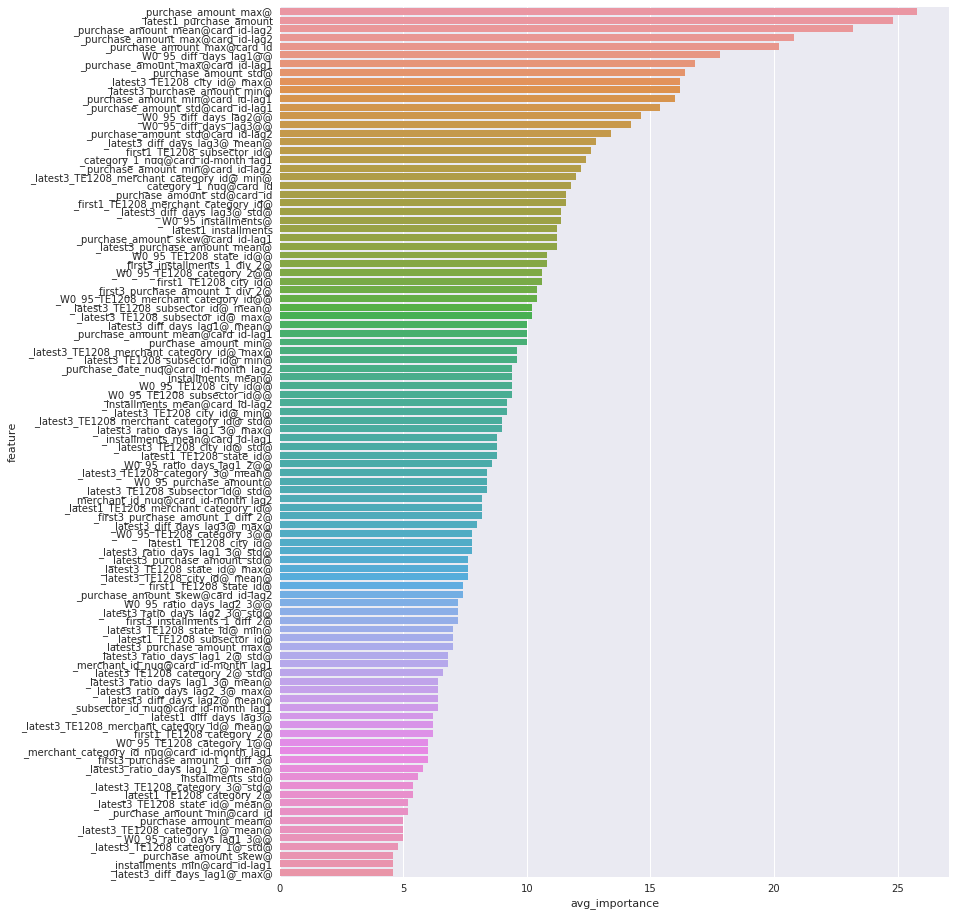

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

feim = pd.read_csv('../valid/1202_100_lgb__feat176_CV3.8178048421130235_lr0.1.csv')
plt.figure(figsize=(12, 16))
sns.barplot(data=feim.sort_values(by='avg_importance', ascending=False).iloc[:100, :], x='avg_importance', y='feature')
plt.show()